In [1]:
%cd ..\src
!python setup.py develop

c:\Users\mscer\dev\EchoVPR\src
running develop
running egg_info
writing echovpr.egg-info\PKG-INFO
writing dependency_links to echovpr.egg-info\dependency_links.txt
writing top-level names to echovpr.egg-info\top_level.txt
reading manifest file 'echovpr.egg-info\SOURCES.txt'
writing manifest file 'echovpr.egg-info\SOURCES.txt'
running build_ext
Creating c:\users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\echovpr.egg-link (link to .)
echovpr 1.0 is already the active version in easy-install.pth

Installed c:\users\mscer\dev\echovpr\src
Processing dependencies for echovpr==1.0
Finished processing dependencies for echovpr==1.0


C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\mscer\anaconda3\envs\patchnetvlad\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


In [2]:
from os.path import isfile, join

import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import numpy as np

from configs.utils import get_config, get_bool_from_config
from echovpr.datasets.utils import load_np_file, get_subset_dataset
from echovpr.models.utils import get_sparsity
from echovpr.models.single_esn import SingleESN
from echovpr.models.sparce_layer import SpaRCe
from echovpr.trainer.utils.simple_processor import process_dataset

import logging

logging.basicConfig(level=logging.INFO)
log = logging.getLogger()

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

In [3]:
config = get_config("configs\\train_esn_oxford.ini", log=False)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
artifact_name = 'mscerri/echovpr_oxford_esn/esn_i32f1sez:v0'

In [6]:
run = wandb.init()
artifact = run.use_artifact(artifact_name, type='model')
artifact_dir = artifact.download()

model_file = join(artifact_dir, 'model.pt')
esn_model_file = join(artifact_dir, 'esn_model.pt')

all_in_one = not isfile(esn_model_file)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mscerri (use `wandb login --relogin` to force relogin)


In [7]:
in_features=int(config['model_in_features'])
reservoir_size=int(config['model_reservoir_size'])
out_features=int(config['model_out_features'])

esn_alpha = float(config['model_esn_alpha'])
esn_gamma = float(config['model_esn_gamma'])
esn_rho = float(config['model_esn_rho'])
esn_num_connections = int(config['model_esn_num_connections'])
sparce_enabled = get_bool_from_config(config, 'model_sparce_enabled')

model = nn.ModuleDict()

esn_model = SingleESN(
  in_features, 
  reservoir_size, 
  alpha=esn_alpha, 
  gamma=esn_gamma, 
  rho=esn_rho,
  sparsity=get_sparsity(esn_num_connections, reservoir_size),
  device=device
)

if all_in_one:
  model["esn"] = esn_model

if sparce_enabled:
  model["sparce"] = SpaRCe(reservoir_size)

model["out"] = nn.Linear(in_features=reservoir_size, out_features=out_features, bias=True)

In [8]:
if not all_in_one:
  esn_model.load_state_dict(torch.load(esn_model_file))

model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [9]:
if not all_in_one:
  esn_model.eval().to(device)
  
model.eval().to(device)

ModuleDict(
  (out): Linear(in_features=1250, out_features=4599, bias=True)
)

In [10]:
day_hidden_repr = torch.from_numpy(load_np_file(config['dataset_oxford_day_hidden_repr_file_path']))
night_hidden_repr = torch.from_numpy(load_np_file(config['dataset_oxford_night_hidden_repr_file_path']))

hr_day_dataset = day_hidden_repr
hr_night_dataset = night_hidden_repr

# Normalize dataset
max_n = hr_day_dataset.max()
_ = hr_day_dataset.divide_(max_n)
_ = hr_night_dataset.divide_(max_n)

In [11]:
esn_day_repr  = process_dataset("Day", hr_day_dataset, esn_model, config, device, log)
esn_night_repr  = process_dataset("Night", hr_night_dataset, esn_model, config, device, log)

INFO:root:Start processing Day dataset
INFO:root:Finished processing Day Dataset
INFO:root:Start processing Night dataset
INFO:root:Finished processing Night Dataset


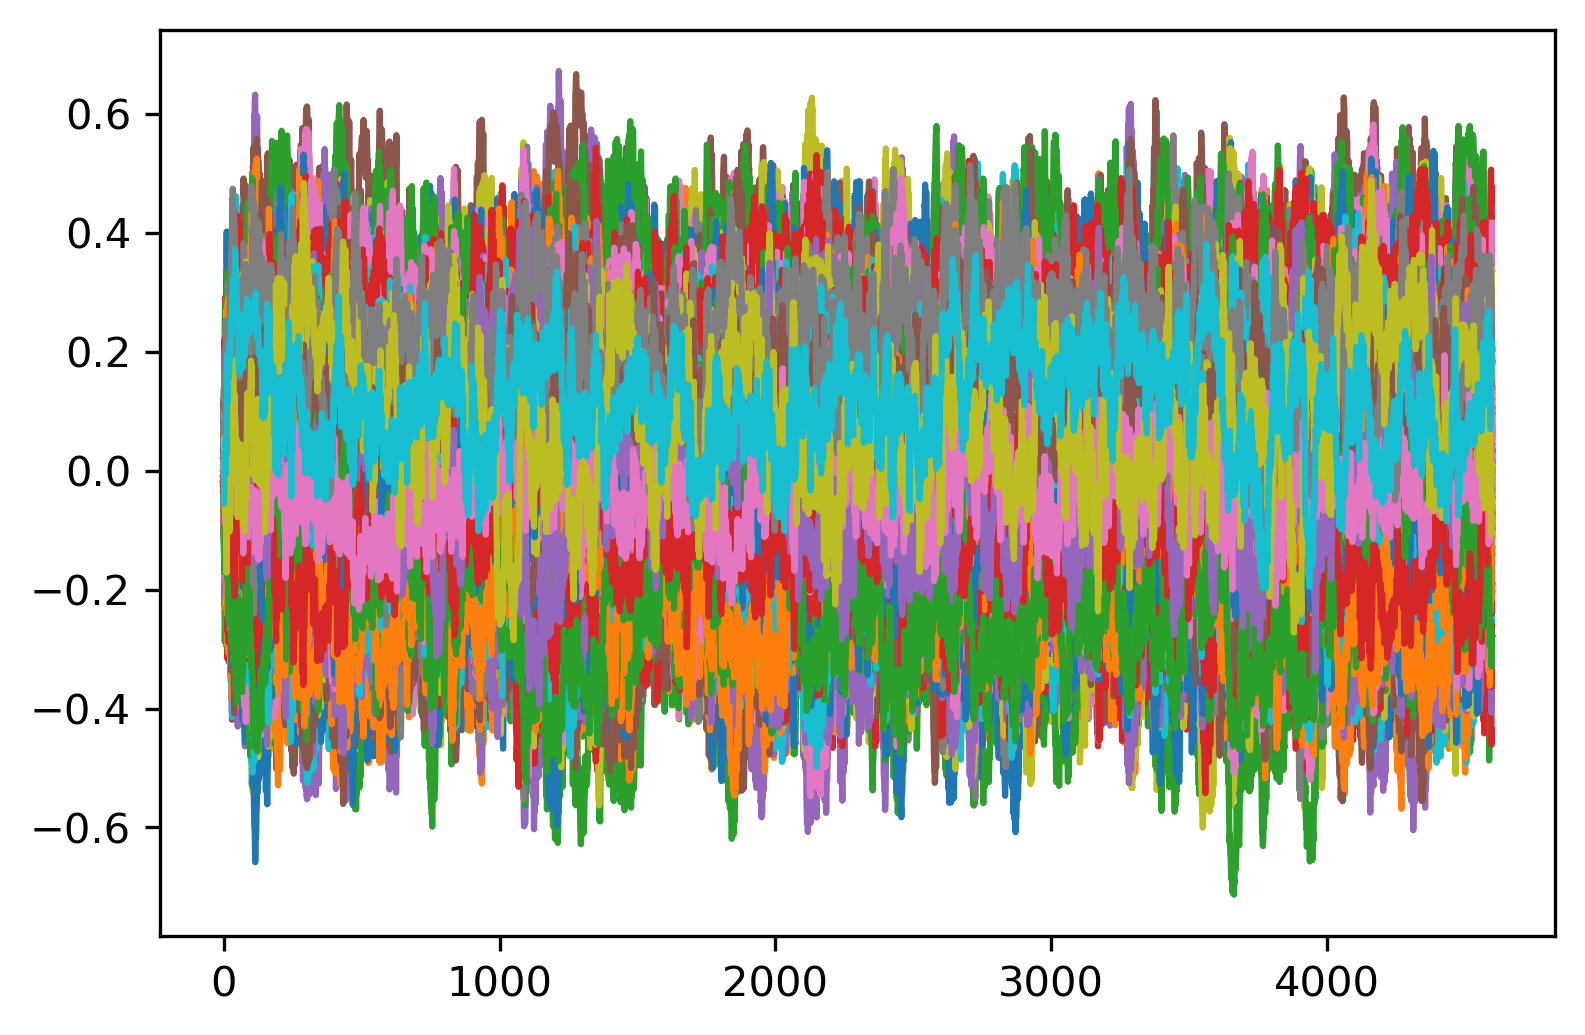

In [17]:
# import matplotlib.pyplot as plt

# for i in range(reservoir_size):
#   plt.plot(esn_day_repr[:, i])

# plt.show()

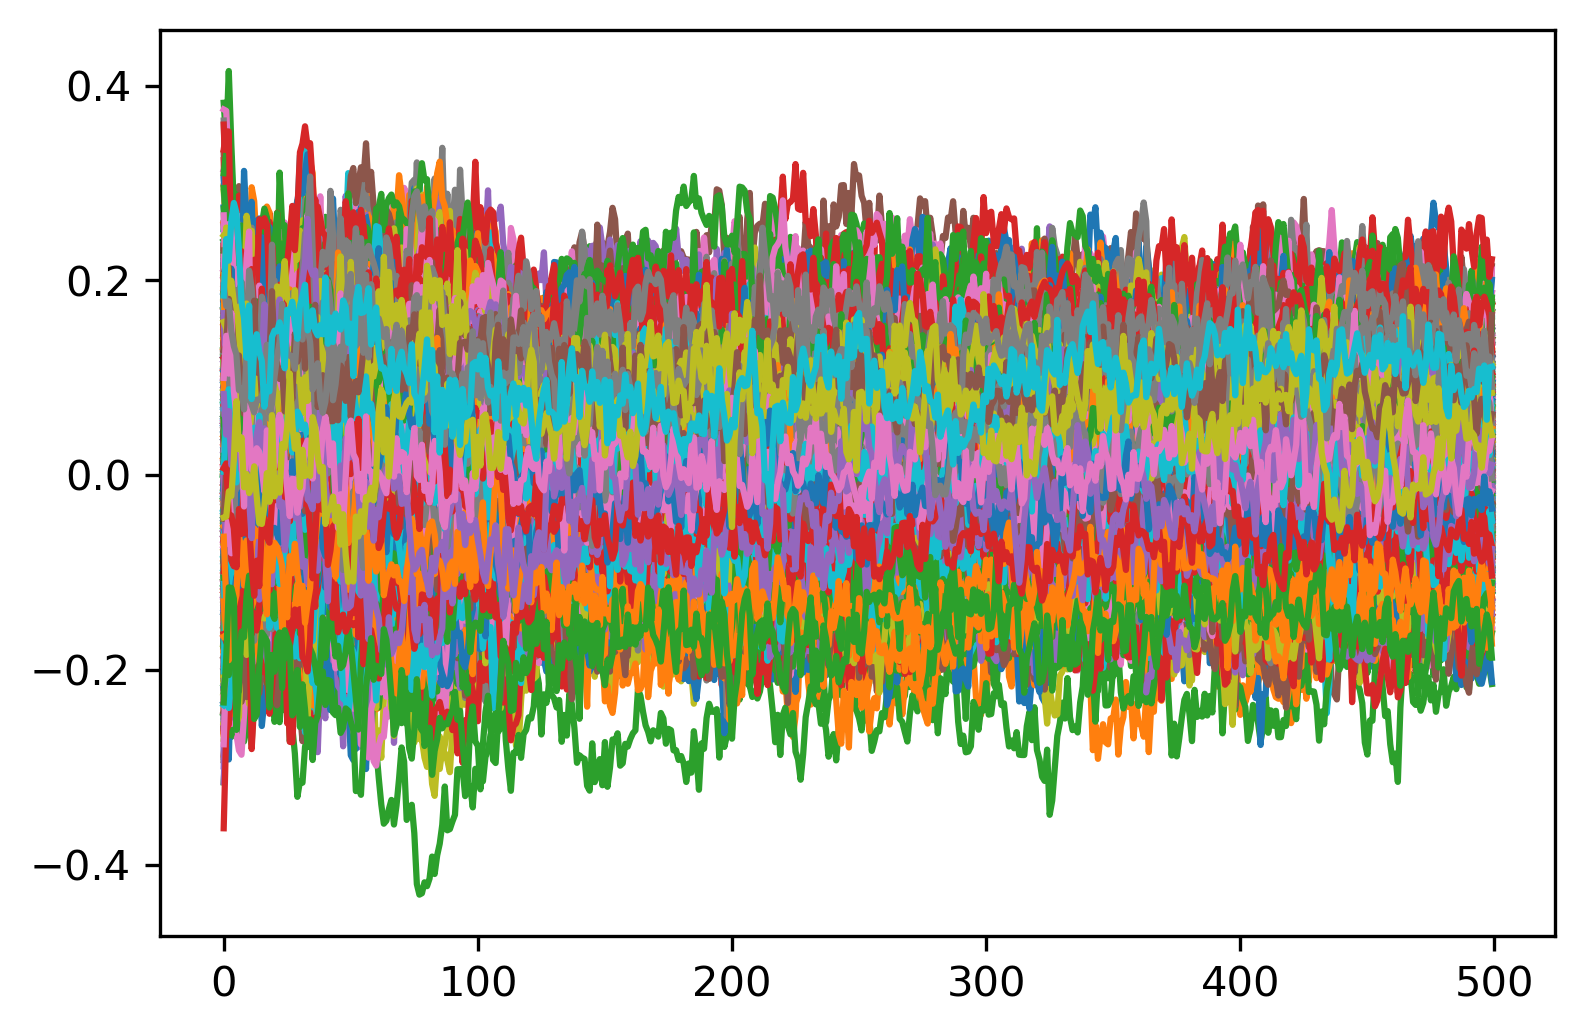

In [19]:
# for i in range(reservoir_size):
#   plt.plot(esn_night_repr[:, i])

# plt.show()